In [1]:
# Note: TFMOT is using Keras version 2 which is only used by default until TensorFlow version 2.15
# The following is required to use the legacy Keras 2 package if TF version > 2.15
# more info: https://keras.io/getting_started/#tensorflow--keras-2-backwards-compatibility
# ! pip install tf_keras

In [2]:
#! pip install tensorflow tensorflow_datasets
# ! pip install setuptools
# ! pip install -U scikit-learn
# ! pip install matplotlib
# ! pip install -q tensorflow-model-optimization

In [3]:
# Note: TFMOT is using Keras version 2 which is only used by default until TensorFlow version 2.15
# The following is required to use the legacy Keras 2 package if TF version > 2.15
# more info: https://keras.io/getting_started/#tensorflow--keras-2-backwards-compatibility
# uncomment the following line if using TF version > 2.15
# ! pip install tf_keras

In [ ]:

import os
# The following line is required to use the legacy Keras 2 package if TF version > 2.15

os.environ['TF_USE_LEGACY_KERAS'] = "1" 
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np




print('tensorflow version', tf.__version__)



tensorflow version 2.18.0


## Load the MNIST dataset 

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


## Build a training pipeline

Apply the following transformations:

tf.data.Dataset.map: TFDS provide images of type tf.uint8, while the model expects tf.float32. Therefore, you need to normalize images.
tf.data.Dataset.cache As you fit the dataset in memory, cache it before shuffling for a better performance.
Note: Random transformations should be applied after caching.
tf.data.Dataset.shuffle: For true randomness, set the shuffle buffer to the full dataset size.
Note: For large datasets that can't fit in memory, use buffer_size=1000 if your system allows it.
tf.data.Dataset.batch: Batch elements of the dataset after shuffling to get unique batches at each epoch.
tf.data.Dataset.prefetch: It is good practice to end the pipeline by prefetching for performance.

In [6]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)


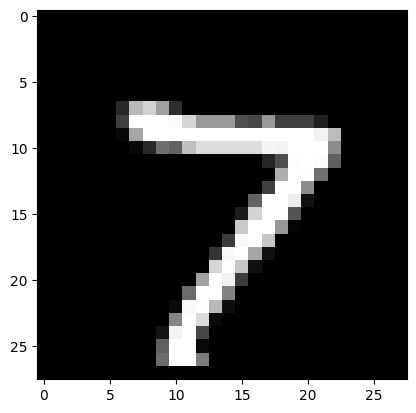

In [7]:
for X, y in ds_test.take(5):
    plt.imshow(X.numpy().reshape(28, 28), cmap='gray')
    print(y)

## Build an evaluation pipeline
Your testing pipeline is similar to the training pipeline with small differences:

You don't need to call tf.data.Dataset.shuffle.
Caching is done after batching because batches can be the same between epochs.

In [8]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Training

In [23]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
print(model.summary())
optimizer = tf.keras.optimizers.legacy.Adam(0.001)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 


 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
469/469 [==============================] - 1s 2ms/step - loss: 0.3613 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.1916 - val_sparse_categorical_accuracy: 0.9442
Epoch 2/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.9532 - val_loss: 0.1330 - val_sparse_categorical_accuracy: 0.9600
Epoch 3/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1178 - sparse_categorical_accuracy: 0.9665 - val_loss: 0.1157 - val_sparse_categorical_accuracy: 0.9656
Epoch 4/6
469/469 [===

## Float32 model prediction

In [24]:
predictions = model.predict(ds_test)
predicted_classes = tf.argmax(predictions, axis=1)

 1/79 [..............................] - ETA: 3s

79/79 [==============================] - 0s 2ms/step


In [25]:
# extract true labels from test set
true_label = tf.concat([y for x, y in ds_test], axis=0)

In [26]:
print('Accuracy is:' , round(accuracy_score(true_label, predicted_classes)*100, 2))

Accuracy is: 97.63


## Float32 model evaluation

In [27]:
print('Accuracy is:' , round(accuracy_score(true_label, predicted_classes)*100, 2))
print('F1 score is:' , round(f1_score(true_label, predicted_classes, average = 'weighted')*100, 2))
print('Recall score is:' , round(recall_score(true_label, predicted_classes, average = 'weighted')*100, 2))
print('Precision score is:' , round(precision_score(true_label, predicted_classes, average = 'weighted')*100, 2))


Accuracy is: 97.63
F1 score is: 97.63
Recall score is: 97.63
Precision score is: 97.63


## Plot loss and accuracy

Text(0.5, 1.0, 'Training and validation loss')

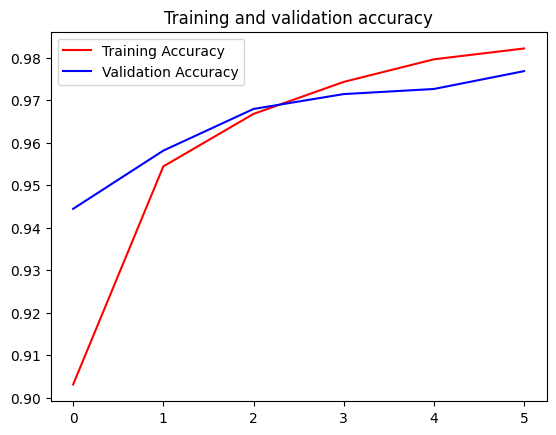

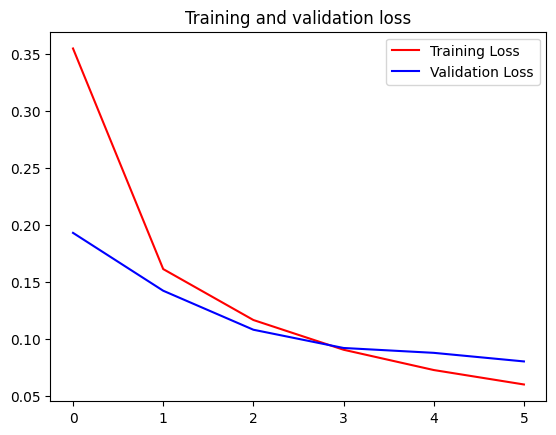

In [14]:
# PLOT LOSS AND ACCURACY

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['sparse_categorical_accuracy']
val_acc=history.history['val_sparse_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.legend()
plt.title('Training and validation accuracy')



#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend()

plt.title('Training and validation loss')


## Save the TF model
In case that you lose the model, save and load

In [28]:
# save model
tf.keras.models.save_model(model, 'tf_mnist_model.h5')

C:\Users\eafssep\AppData\Local\Temp\ipykernel_16964\3891454289.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, 'tf_mnist_model.h5')


## Load the TF model 

In [29]:
# load the tf model

model = tf.keras.models.load_model('tf_mnist_model.h5')

## Quantization Aware Training

In [17]:
# ! pip install -q tensorflow-model-optimization

In [30]:


quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

#`quantize_model` requires a recompile.
q_aware_model.compile(optimizer=optimizer, 
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    

q_aware_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_2 (Quantize  (None, 28, 28)            3         
 Layer)                                                          
                                                                 
 quant_flatten_1 (QuantizeW  (None, 784)               1         
 rapperV2)                                                       
                                                                 
 quant_dense_2 (QuantizeWra  (None, 128)               100485    
 pperV2)                                                         
                                                                 
 quant_dense_3 (QuantizeWra  (None, 10)                1295      
 pperV2)                                                         
                                                                 
Total params: 101784 (397.59 KB)
Trainable params: 101

## Training QAT Model

In [31]:
# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_q_aware = q_aware_model.fit(
                                    ds_train,
                                    epochs=6,
                                    validation_data=ds_test,
                                    )
                           

Epoch 1/6
469/469 [==============================] - 2s 3ms/step - loss: 0.0762 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.0809 - val_sparse_categorical_accuracy: 0.9759
Epoch 2/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9881 - val_loss: 0.0695 - val_sparse_categorical_accuracy: 0.9773
Epoch 3/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.0667 - val_sparse_categorical_accuracy: 0.9795
Epoch 4/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0257 - sparse_categorical_accuracy: 0.9929 - val_loss: 0.0694 - val_sparse_categorical_accuracy: 0.9789
Epoch 5/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0212 - sparse_categorical_accuracy: 0.9946 - val_loss: 0.0678 - val_sparse_categorical_accuracy: 0.9794
Epoch 6/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0178 - sparse_categorical_accu

## TFLite Conversion

In [48]:
# choose the type of conversion

# no quantization
no_quant = False
# full quantization
full_quant = False
# Dynamic Range Quantization
DRQ = False
# float16 quantization
float16_quant = False
# 16x4 quantization
quant_16x8 = False
# quantization aware training
quant_aware = True


if no_quant:
  export_dir = 'saved_model/no_quant'
  tflite_model_file = 'model.tflite'
  input_type = 'float32'
elif DRQ:
  export_dir = 'saved_model/DRQ'
  tflite_model_file = 'model_DRQ.tflite'
  input_type = 'float32'
elif float16_quant:
  export_dir = 'saved_model/float16_quant'
  tflite_model_file = 'model_float16_quant.tflite'
  input_type = 'float32'
elif full_quant:
  export_dir = 'saved_model/full_quant'
  tflite_model_file = 'model_full_quant.tflite'
  input_type = 'int8'
elif quant_16x8:
  export_dir = 'saved_model/quant_16x8'
  tflite_model_file = 'model_quant_16x8.tflite'
  input_type = 'int16'
elif quant_aware:
  export_dir = 'saved_model/quant_aware'
  tflite_model_file = 'model_quant_aware.tflite'
  input_type = 'int8'


# # representative dataset
# def representative_data():
#   for input_value in tf.data.Dataset.from_tensor_slices(X_test).batch(1).take(100):
#     input_value = tf.cast(input_value, tf.float32)
#     # Model has only one input so each data point has one element.
#     yield [input_value]

def representative_data():
  for image_batch, labels_batch in ds_test.take(1):
    yield [image_batch]

tf.saved_model.save(model, export_dir)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) # path to the SavedModel directory

# Add optimization (Dynamic range quantization)
if DRQ: converter.optimizations = [tf.lite.Optimize.DEFAULT]

if float16_quant:
   converter.optimizations = [tf.lite.Optimize.DEFAULT]
   converter.target_spec.supported_types = [tf.float16]
   
  
if full_quant:
  # Full integer quantization for all ops including the input and output
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.int8  
  converter.inference_output_type = tf.int8 


if quant_16x8:
  # 16x8 quantization
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
  converter.representative_dataset = representative_data
  converter.inference_input_type = tf.int16  
  converter.inference_output_type = tf.int16 

if quant_aware:
  # quantization aware training
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data
  converter.inference_input_type = tf.int8  
  converter.inference_output_type = tf.int8 

tflite_model = converter.convert()

# Save the model.
with open(tflite_model_file, 'wb') as f:
  f.write(tflite_model)


# print(help(tf.lite.TFLiteConverter))


INFO:tensorflow:Assets written to: saved_model/quant_aware\assets


INFO:tensorflow:Assets written to: saved_model/quant_aware\assets


## TFLite Interpreter

In [33]:

interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()  # Needed before execution!

output_details = interpreter.get_output_details()[0]  # Model has single output.
input_details = interpreter.get_input_details()[0]  # Model has single input.
print(input_details.get('dtype'))
print(output_details.get('dtype'))


<class 'numpy.int8'>
<class 'numpy.int8'>


In [45]:
input_details

{'name': 'serving_default_flatten_1_input:0',
 'index': 0,
 'shape': array([ 1, 28, 28]),
 'shape_signature': array([-1, 28, 28]),
 'dtype': numpy.int8,
 'quantization': (0.003921568859368563, -128),
 'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
  'zero_points': array([-128]),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

## TFLite Prediction

In [52]:
pred_list = []
# np.zeros(ds_test.shape)
for X_test, y_test in ds_test.take(1):
    y_pred = np.zeros(y_test.shape)
    for i in range (len(X_test)):
        X_test_input = np.reshape(X_test[i], (1, 28, 28))
        # Check if the input type is quantized, then rescale input data to int
        if input_details['dtype'] == np.int8 or input_details['dtype'] == np.int16:
            input_scale, input_zero_point = input_details["quantization"]
            X_test_input = X_test_input / input_scale + input_zero_point
            X_test_input = np.array(X_test_input, dtype=input_details["dtype"])

            interpreter.set_tensor(input_details['index'], X_test_input)
            interpreter.invoke()
            prediction = interpreter.get_tensor(output_details['index'])
            # keeping all predictions in a list
            pred_list.append(prediction)
            y_pred[i] = np.argmax(prediction, axis = 1)         

C:\Users\eafssep\AppData\Local\Temp\ipykernel_16964\1915932834.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = np.argmax(prediction, axis = 1)


## TFLite Evaluation

In [54]:
print('Accuracy is:' , round(accuracy_score(y_test, y_pred)*100, 2))
print('F1 score is:' , round(f1_score(y_test, y_pred, average = 'macro')*100, 2))
print('Recall score is:' , round(recall_score(y_test, y_pred, average = 'macro')*100, 2))
print('Precision score is:' , round(precision_score(y_test, y_pred, average = 'macro')*100, 2))

Accuracy is: 97.66
F1 score is: 97.4
Recall score is: 97.75
Precision score is: 97.35
